In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller

# Load the dataset
file_path = "S&P500_L5Y.csv"  # Update this if needed
df = pd.read_csv(file_path)

# Convert Date column to datetime format and sort in ascending order
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.sort_values(by='Date')

# Rename 'Close/Last' for easier reference
df.rename(columns={'Close/Last': 'Close'}, inplace=True)

# Compute log returns
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Drop first row due to NaN in log returns
df = df.dropna()

# Perform Augmented Dickey-Fuller test
adf_test = adfuller(df['Log_Returns'])
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])
print("Is the series stationary?", adf_test[1] < 0.05)  # Null hypothesis: non-stationary

# Split into training (256 weeks) and testing (4 weeks)
train_size = 256 * 5  # 1280 days
test_size = 4 * 5  # 20 days

train_data = df.iloc[:-test_size]  # All but the last 20 days
test_data = df.iloc[-test_size:]  # Last 20 days

# Save to CSV if needed
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

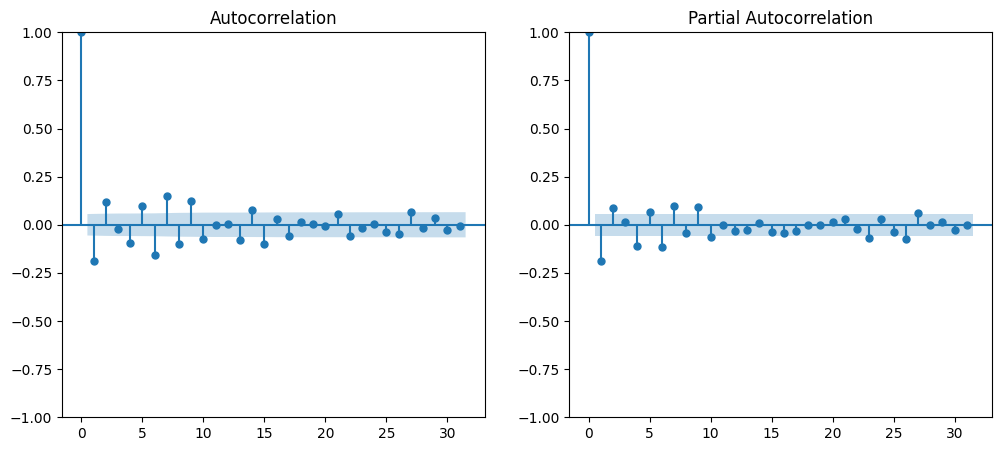

/Users/ingridrotvold/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ingridrotvold/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ingridrotvold/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Log_Returns   No. Observations:                 1235
Model:                 ARIMA(1, 0, 1)   Log Likelihood                3608.937
Date:                Thu, 06 Mar 2025   AIC                          -7209.874
Time:                        10:51:39   BIC                          -7189.399
Sample:                             0   HQIC                         -7202.172
                               - 1235                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.685      0.092   -9.46e-05       0.001
ar.L1         -0.4878      0.048    -10.079      0.000      -0.583      -0.393
ma.L1          0.2989      0.055      5.469      0.0

/Users/ingridrotvold/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ingridrotvold/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


NameError: name 'mean_squared_error' is not defined

In [4]:

# Load preprocessed data
df = pd.read_csv("train_data.csv")  # Load the training dataset
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Plot ACF and PACF to determine p and q
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df['Log_Returns'], ax=axes[0])  # Identify q
plot_pacf(df['Log_Returns'], ax=axes[1])  # Identify p
plt.show()

# Fit ARIMA model (use d=0 since log returns are already stationary)
p, d, q = 1, 0, 1  # Adjust based on ACF/PACF analysis
model = ARIMA(df['Log_Returns'], order=(p, d, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Forecast future log returns for the test period
test_df = pd.read_csv("test_data.csv")
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.set_index('Date', inplace=True)

forecast = model_fit.forecast(steps=len(test_df))

# Evaluate the model
rmse = np.sqrt(mean_squared_error(test_df['Log_Returns'], forecast))
mae = mean_absolute_error(test_df['Log_Returns'], forecast)

print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")

# Plot actual vs. predicted
plt.figure(figsize=(10,5))
plt.plot(test_df.index, test_df['Log_Returns'], label="Actual Log Returns", marker='o')
plt.plot(test_df.index, forecast, label="Predicted Log Returns", linestyle='dashed', marker='x')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()
